In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Function to load datasets into a dictionary
def load_datasets(file_names):
    datasets = {}
    for name in file_names:
        file_path = f'olist_{name}_dataset.csv'
        try:
            datasets[name] = pd.read_csv(file_path)
        except FileNotFoundError:
            print(f"File not found: {file_path}")
    return datasets

# Dataset names
dataset_names = [
    'customers', 
    'order_items', 
    'order_payments', 
    'order_reviews', 
    'orders', 
    'sellers', 
    'products', 
    'product_category_name_translation'
]

# Loading each dataset using the function
datasets = load_datasets(dataset_names)

# Displaying the first few rows of each dataset to understand their structure
for name, df in datasets.items():
    if df is not None:
        print(f"\nFirst few rows of {name} dataset:")
        print(df.head())



First few rows of customers dataset:
                        customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP  
3                      8775        mogi das cruzes             SP  
4                     13056               campinas             SP  

First few rows of order_items dataset:
                           order_id  order_item_id  \
0  00010242fe8c5a6d1b

In [2]:
def merge_datasets(datasets):
    # Start by merging orders with customers
    merged = pd.merge(datasets['orders'], datasets['customers'], on='customer_id', how='left')

    # Add other datasets with the correct merge keys
    merge_keys = {
        'order_items': 'order_id',
        'order_payments': 'order_id',
        'order_reviews': 'order_id',
        'sellers': 'seller_id',
        'products': 'product_id',
        'product_category_name_translation': 'product_category_name'
    }

    for name, key in merge_keys.items():
        if name in datasets:
            merged = pd.merge(merged, datasets[name], on=key, how='left')

    return merged

merged_df = merge_datasets(datasets)

# applying data cleaning to new csv file
merged_df.to_csv('olist_merged_data.csv', index=False)

In [3]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119143 entries, 0 to 119142
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       119143 non-null  object 
 1   customer_id                    119143 non-null  object 
 2   order_status                   119143 non-null  object 
 3   order_purchase_timestamp       119143 non-null  object 
 4   order_approved_at              118966 non-null  object 
 5   order_delivered_carrier_date   117057 non-null  object 
 6   order_delivered_customer_date  115722 non-null  object 
 7   order_estimated_delivery_date  119143 non-null  object 
 8   customer_unique_id             119143 non-null  object 
 9   customer_zip_code_prefix       119143 non-null  int64  
 10  customer_city                  119143 non-null  object 
 11  customer_state                 119143 non-null  object 
 12  order_item_id                 

In [4]:
# check for duplicates
merged_df.duplicated().sum()

0

In [5]:
# check for missing values by percentage in each column
merged_df.isnull().sum() / len(merged_df) * 100

order_id                          0.000000
customer_id                       0.000000
order_status                      0.000000
order_purchase_timestamp          0.000000
order_approved_at                 0.148561
order_delivered_carrier_date      1.750837
order_delivered_customer_date     2.871339
order_estimated_delivery_date     0.000000
customer_unique_id                0.000000
customer_zip_code_prefix          0.000000
customer_city                     0.000000
customer_state                    0.000000
order_item_id                     0.699160
product_id                        0.699160
seller_id                         0.699160
shipping_limit_date               0.699160
price                             0.699160
freight_value                     0.699160
payment_sequential                0.002518
payment_type                      0.002518
payment_installments              0.002518
payment_value                     0.002518
review_id                         0.836810
review_scor

In [6]:
# drop missing values column with more than 50% missing values
merged_df = merged_df.dropna(thresh=len(merged_df) * 0.5, axis=1)

# drop rows with missing values
merged_df = merged_df.dropna()

In [7]:
# check for missing values by percentage in each column
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113193 entries, 0 to 119142
Data columns (total 38 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       113193 non-null  object 
 1   customer_id                    113193 non-null  object 
 2   order_status                   113193 non-null  object 
 3   order_purchase_timestamp       113193 non-null  object 
 4   order_approved_at              113193 non-null  object 
 5   order_delivered_carrier_date   113193 non-null  object 
 6   order_delivered_customer_date  113193 non-null  object 
 7   order_estimated_delivery_date  113193 non-null  object 
 8   customer_unique_id             113193 non-null  object 
 9   customer_zip_code_prefix       113193 non-null  int64  
 10  customer_city                  113193 non-null  object 
 11  customer_state                 113193 non-null  object 
 12  order_item_id                 

In [8]:
# Clean and preprocess data
def preprocess_data(df):
    # Drop columns with more than 50% missing values
    df.dropna(thresh=len(df) * 0.5, axis=1, inplace=True)
    
    # Convert datetime columns
    datetime_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
                    'order_delivered_customer_date', 'order_estimated_delivery_date', 
                    'shipping_limit_date', 'review_creation_date', 'review_answer_timestamp']
    for col in datetime_cols:
        df[col] = pd.to_datetime(df[col], errors='coerce')
    
    # Calculate new features
    df['time_to_delivery'] = (df['order_delivered_customer_date'] - df['order_approved_at']).dt.days
    df['order_processing_time'] = (df['order_approved_at'] - df['order_purchase_timestamp']).dt.days
    df['estimated_vs_actual_shipping'] = (df['order_estimated_delivery_date'] - df['order_delivered_customer_date']).dt.days
    df['product_volume_m3'] = (df['product_length_cm'] * df['product_width_cm'] * df['product_height_cm']) / 1000000
    df['satisfaction'] = (df['review_score'] >= 4).astype(int)
    df['order_value'] = df['price'] + df['freight_value']

    # create late delivery flag
    df['late_delivery'] = (df['order_delivered_customer_date'] > df['order_estimated_delivery_date']).astype(int)


    # Drop rows with missing values
    df.dropna(inplace=True)

    # create seasonal features from order_purchase_timestamp
    df['order_month'] = df['order_purchase_timestamp'].dt.month
    df['order_day'] = df['order_purchase_timestamp'].dt.dayofweek
    df['order_hour'] = df['order_purchase_timestamp'].dt.hour

    return df

merged_df = preprocess_data(merged_df)

In [9]:
# drop unnecessary columns
merged_df.drop(['product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'review_score', 'seller_zip_code_prefix', 'product_length_cm','product_height_cm', 'product_width_cm','order_estimated_delivery_date']
               , axis=1, inplace=True) 

In [10]:
# save the cleaned dataset
merged_df.to_csv('olist_merged_data_clean.csv', index=False)

In [11]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113193 entries, 0 to 119142
Data columns (total 39 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       113193 non-null  object        
 1   customer_id                    113193 non-null  object        
 2   order_status                   113193 non-null  object        
 3   order_purchase_timestamp       113193 non-null  datetime64[ns]
 4   order_approved_at              113193 non-null  datetime64[ns]
 5   order_delivered_carrier_date   113193 non-null  datetime64[ns]
 6   order_delivered_customer_date  113193 non-null  datetime64[ns]
 7   customer_unique_id             113193 non-null  object        
 8   customer_zip_code_prefix       113193 non-null  int64         
 9   customer_city                  113193 non-null  object        
 10  customer_state                 113193 non-null  object        
 11  

In [12]:
# check summary statistics
merged_df.describe()

,customer_zip_code_prefix,order_item_id,price,freight_value,payment_sequential,payment_installments,payment_value,product_weight_g,time_to_delivery,order_processing_time,estimated_vs_actual_shipping,product_volume_m3,satisfaction,order_value,late_delivery,order_month,order_day,order_hour
count,113193.000000,113193.000000,113193.000000,113193.000000,113193.000000,113193.000000,113193.000000,113193.000000,113193.00000,113193.000000,113193.000000,113193.000000,113193.000000,113193.000000,113193.000000,113193.000000,113193.000000,113193.000000
mean,35085.687437,1.195065,119.846650,20.002595,1.090818,2.943680,171.557922,2106.236075,11.51899,0.269142,11.091092,0.015306,0.768210,139.849246,0.076984,6.037432,2.746928,14.764614
std,29867.822574,0.687526,181.079901,15.711728,0.686674,2.779181,264.197701,3765.207714,9.32641,0.747635,10.090406,0.023409,0.421977,188.111745,0.266567,3.221918,1.961298,5.324879
min,1003.000000,1.000000,0.850000,0.000000,1.000000,0.000000,0.000000,0.000000,-7.00000,0.000000,-189.000000,0.000168,0.000000,6.080000,0.000000,1.000000,0.000000,0.000000
25%,11310.000000,1.000000,39.900000,13.080000,1.000000,1.000000,60.850000,300.000000,6.00000,0.000000,6.000000,0.002856,1.000000,55.260000,0.000000,3.000000,1.000000,11.000000
50%,24315.000000,1.000000,74.900000,16.320000,1.000000,2.000000,107.960000,700.000000,9.00000,0.000000,12.000000,0.006612,1.000000,91.780000,0.000000,6.000000,3.000000,15.000000
75%,58865.000000,1.000000,132.980000,21.190000,1.000000,4.000000,189.150000,1800.000000,15.00000,0.000000,16.000000,0.018468,1.000000,157.300000,0.000000,8.000000,4.000000,19.000000
max,99980.000000,21.000000,6735.000000,409.680000,26.000000,24.000000,13664.080000,40425.000000,208.00000,30.000000,146.000000,0.296208,1.000000,6929.310000,1.000000,12.000000,6.000000,23.000000


In [13]:
# Check the distribution of the CSAT percentage
merged_df['satisfaction'].value_counts() / len(merged_df) * 100

1    76.821005
0    23.178995
Name: satisfaction, dtype: float64

C:\Users\moham\AppData\Local\Temp\ipykernel_22168\1897957356.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(merged_df.corr(), annot=True, cmap='coolwarm')


<Axes: >

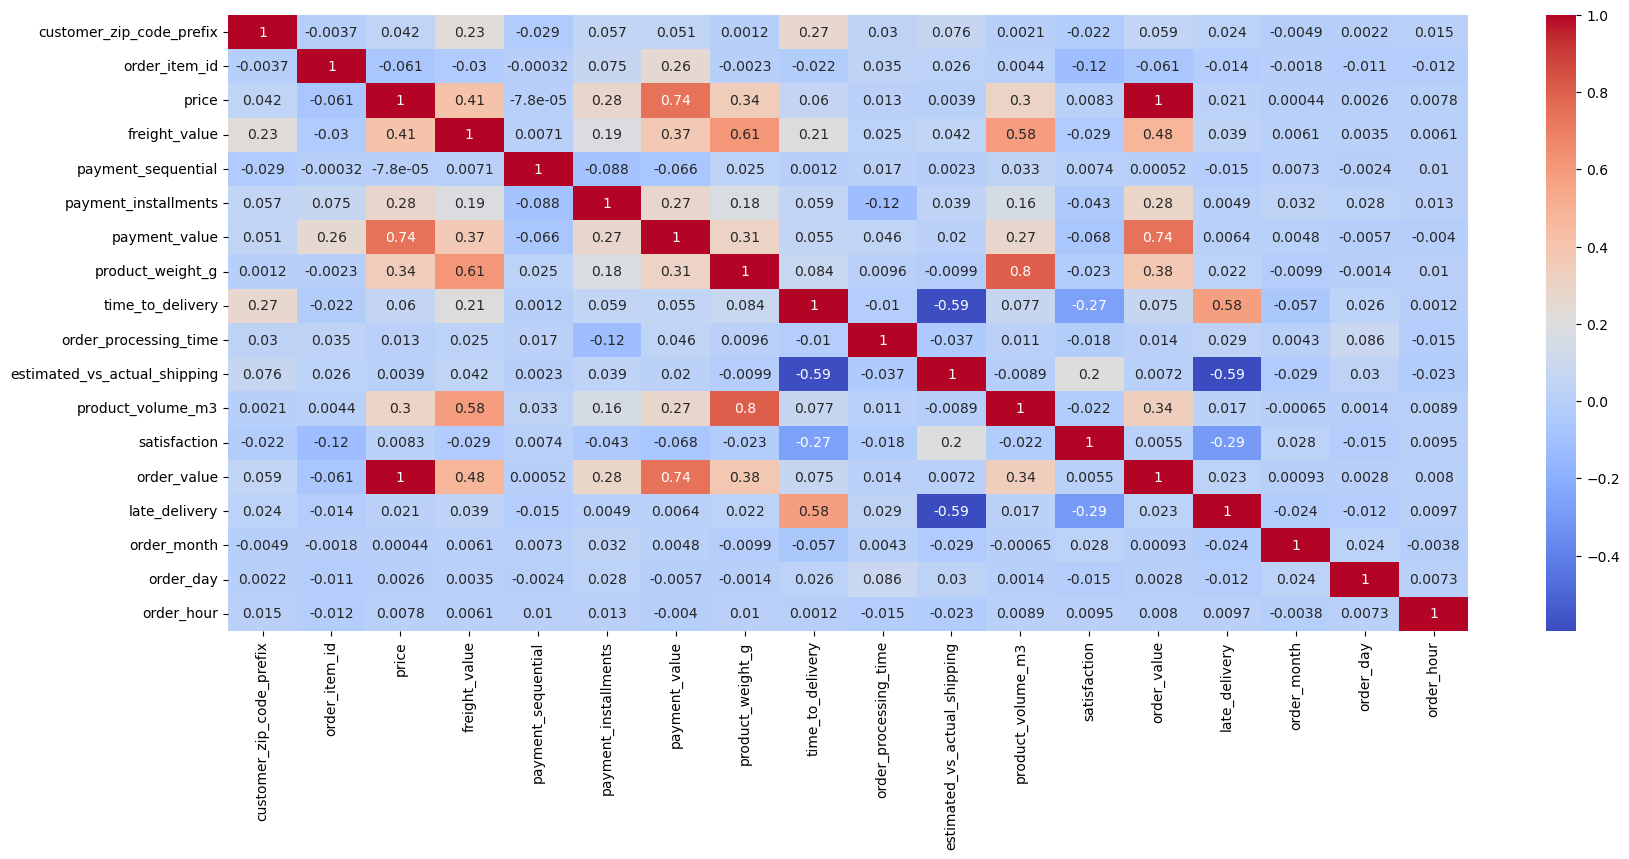

In [14]:
# plot the correlation matrix heatmap figure size
plt.figure(figsize=(20, 8))
sns.heatmap(merged_df.corr(), annot=True, cmap='coolwarm')

# Univariate Analysis

1. Sales Trends Over Time

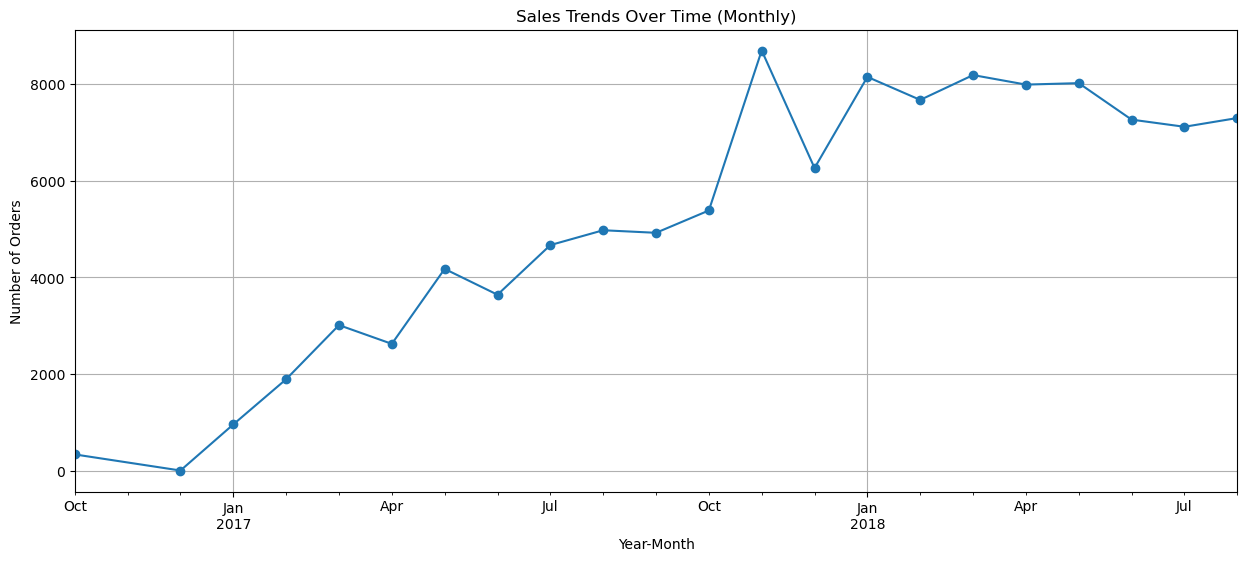

In [15]:
# Ensure that the order_purchase_timestamp is in datetime format
merged_df['order_purchase_timestamp'] = pd.to_datetime(merged_df['order_purchase_timestamp'])

# Extract year and month for aggregation
merged_df['year_month'] = merged_df['order_purchase_timestamp'].dt.to_period('M')

# Aggregate data by year and month
sales_trends = merged_df.groupby('year_month').size()

# Plotting
plt.figure(figsize=(15, 6))
sales_trends.plot(kind='line', marker='o')
plt.title('Sales Trends Over Time (Monthly)')
plt.xlabel('Year-Month')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.show()


### We can see an increase in the Sales trend over months, and its peaks at November 2017.

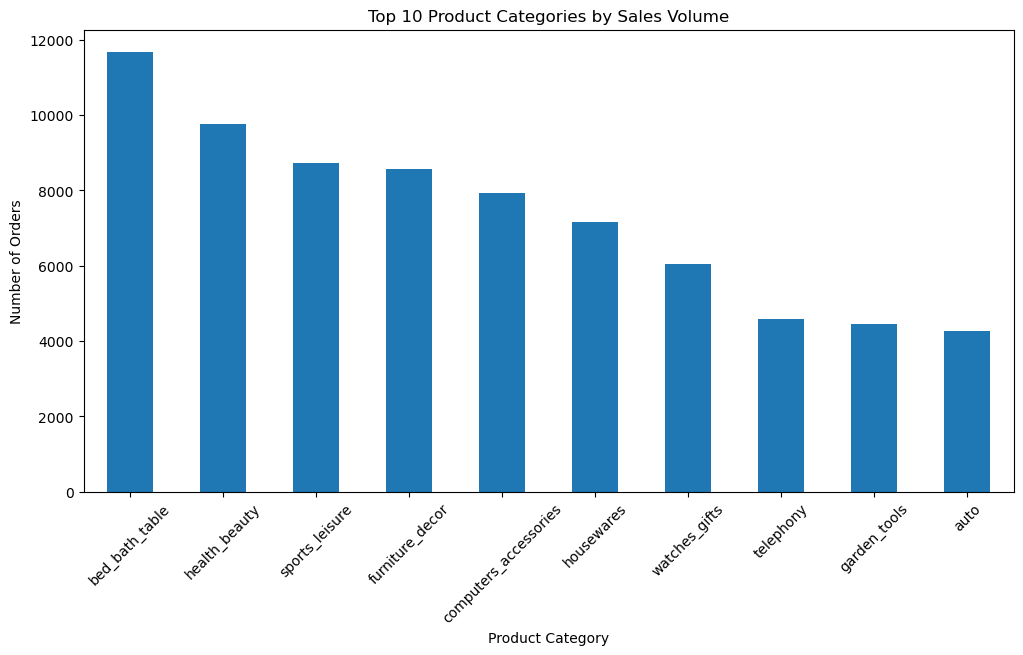

In [16]:
# Grouping data by product category
category_analysis = merged_df.groupby('product_category_name_english').size().sort_values(ascending=False)

# Plotting the top 10 product categories by sales volume
plt.figure(figsize=(12, 6))
category_analysis.head(10).plot(kind='bar')
plt.title('Top 10 Product Categories by Sales Volume')
plt.xlabel('Product Category')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.show()


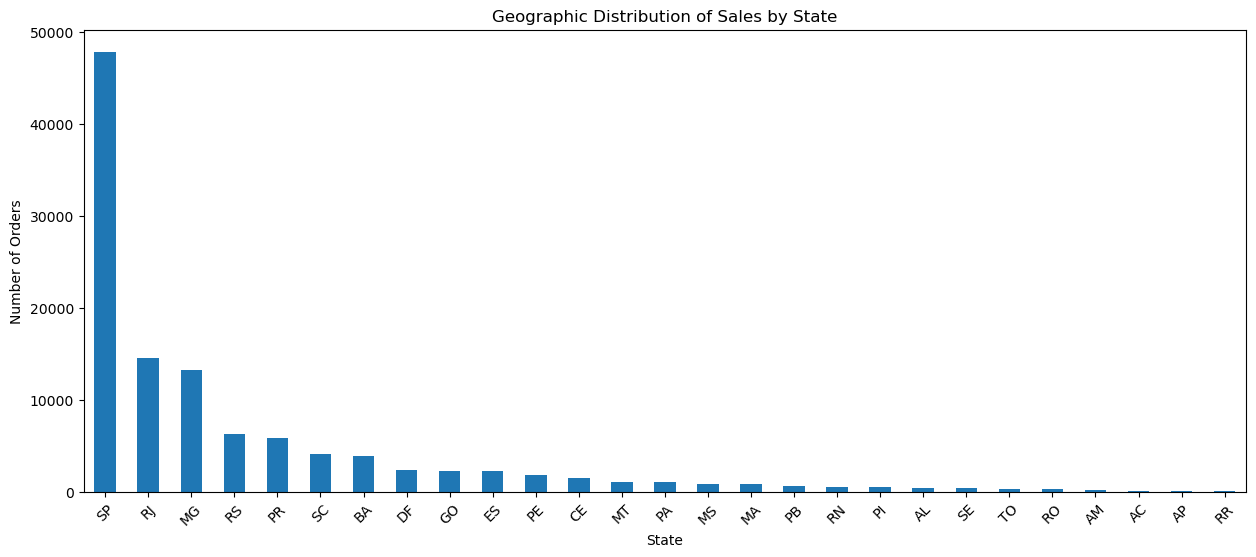

In [17]:
# Grouping data by customer state
state_sales = merged_df.groupby('customer_state').size().sort_values(ascending=False)

# Plotting sales distribution by state
plt.figure(figsize=(15, 6))
state_sales.plot(kind='bar')
plt.title('Geographic Distribution of Sales by State')
plt.xlabel('State')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.show()


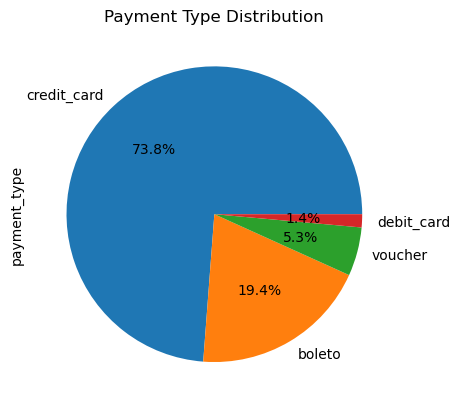

In [18]:
# payment type
merged_df['payment_type'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Payment Type Distribution')
plt.show()

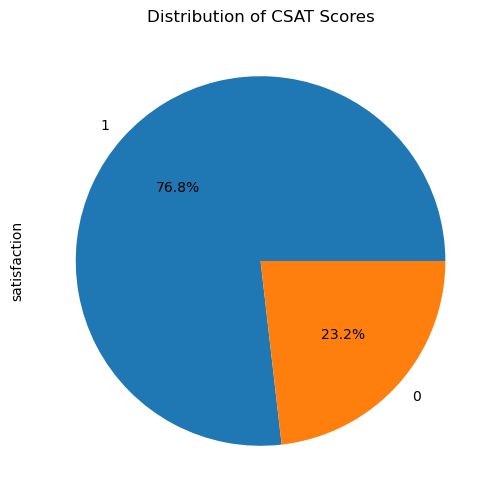

In [19]:
# Distribution of CSAT percentages on pie chart
plt.figure(figsize=(12, 6))
merged_df['satisfaction'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of CSAT Scores')
plt.show()

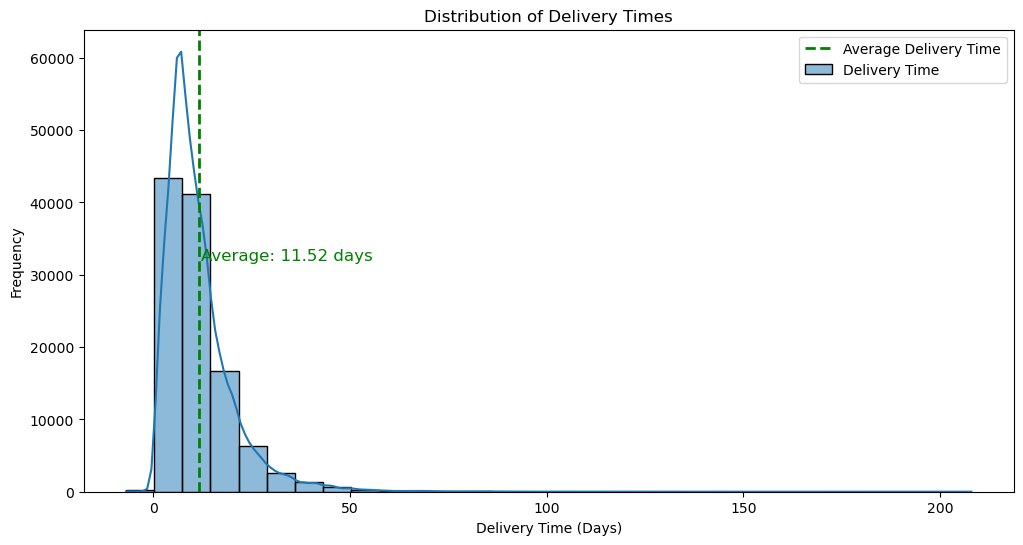

In [20]:
# Calculate the average delivery time
average_delivery_time = merged_df['time_to_delivery'].mean()

# Plot the distribution of delivery times
plt.figure(figsize=(12, 6))
sns.histplot(merged_df['time_to_delivery'].dropna(), bins=30, kde=True, label='Delivery Time')
plt.axvline(average_delivery_time, color='green', linestyle='dashed', linewidth=2, label='Average Delivery Time')
plt.text(average_delivery_time + 0.5, plt.ylim()[1] / 2, f'Average: {average_delivery_time:.2f} days', color='green', fontsize=12, ha='left')
plt.title('Distribution of Delivery Times')
plt.xlabel('Delivery Time (Days)')
plt.ylabel('Frequency')
plt.legend()
plt.show()


### We found that the average delivery time is 11.52 days.

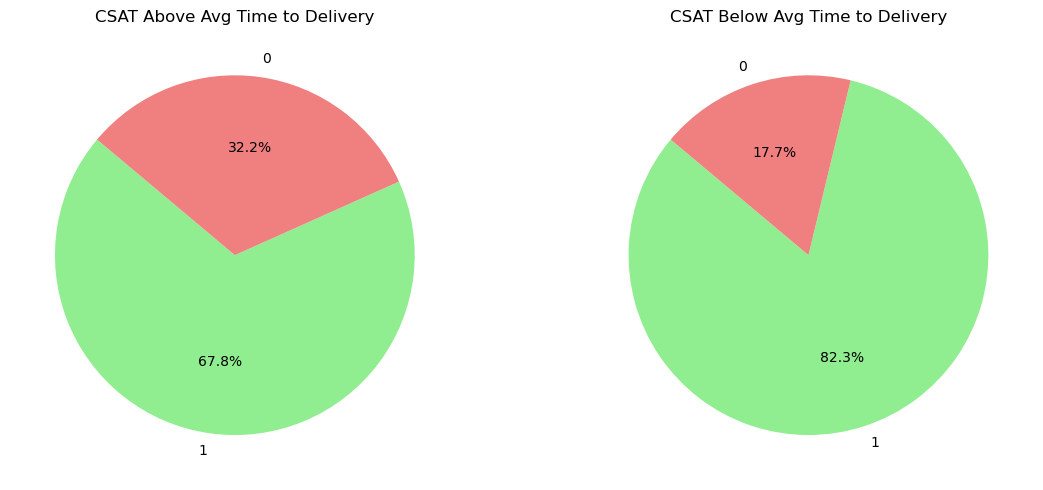

In [21]:
# Calculate the average delivery time
average_delivery_time = merged_df['time_to_delivery'].mean()

# Initialize counts and labels lists for CSAT categories
csat_labels_above, csat_labels_below = [], []
csat_counts_above, csat_counts_below = [], []

# Filter the DataFrame for CSAT values above and below average time_to_delivery
csat_above_avg = merged_df[merged_df['time_to_delivery'] >= average_delivery_time]
csat_below_avg = merged_df[merged_df['time_to_delivery'] < average_delivery_time]

# Calculate the counts for CSAT categories above average time_to_delivery
csat_counts_above = csat_above_avg['satisfaction'].value_counts().tolist()
csat_labels_above = csat_above_avg['satisfaction'].value_counts().index.tolist()

# Calculate the counts for CSAT categories below average time_to_delivery
csat_counts_below = csat_below_avg['satisfaction'].value_counts().tolist()
csat_labels_below = csat_below_avg['satisfaction'].value_counts().index.tolist()

# Create data for the pie charts
colors = ['lightgreen', 'lightcoral']

# Create the two pie charts
plt.figure(figsize=(12, 5))

# Pie chart for CSAT above average time_to_delivery
plt.subplot(1, 2, 1)
plt.pie(csat_counts_above, labels=csat_labels_above, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('CSAT Above Avg Time to Delivery')

# Pie chart for CSAT below average time_to_delivery
plt.subplot(1, 2, 2)
plt.pie(csat_counts_below, labels=csat_labels_below, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('CSAT Below Avg Time to Delivery')

plt.tight_layout()
plt.show()

### We can see that the higher CSAT scores are mostly above average.

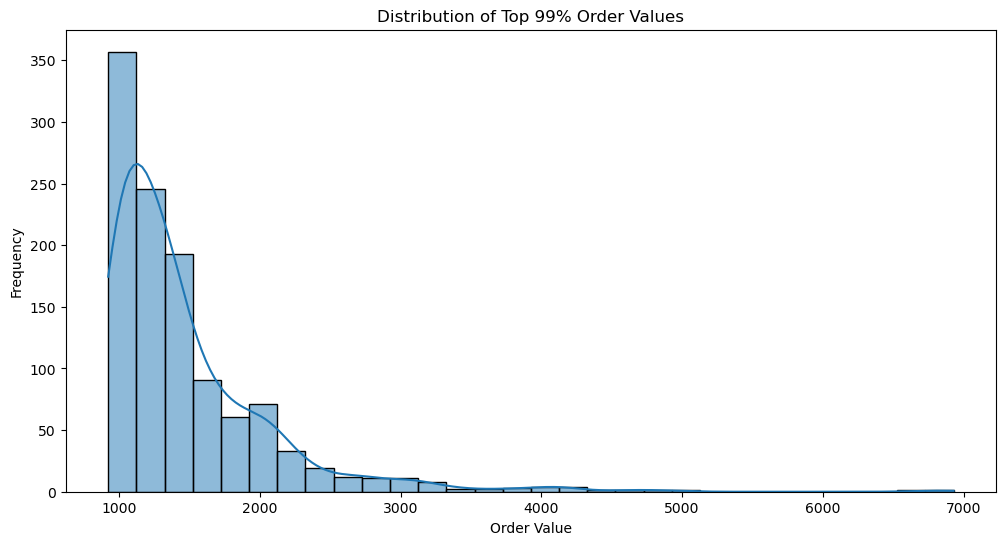

In [22]:
# Calculate the 99th percentile of order values
percentile_99 = np.percentile(merged_df['order_value'], 99)

# Filter the DataFrame to get order values greater than or equal to the 99th percentile
top_1_percent_values = merged_df[merged_df['order_value'] >= percentile_99]['order_value']

# Create a histogram for the top 1% order values
plt.figure(figsize=(12, 6))
sns.histplot(top_1_percent_values, bins=30, kde=True)
plt.title('Distribution of Top 99% Order Values')
plt.xlabel('Order Value')
plt.ylabel('Frequency')
plt.show()

### Distribution of Top 99% Order Values is between 0 and 2000 and right skewed.

# Bivariate Analysis

In [23]:
# Group by month to calculate average Time to Delivery and proportion of late deliveries
monthly_delivery_stats = merged_df.groupby('order_month').agg(
    avg_time_to_delivery=('time_to_delivery', 'mean'),
    proportion_late=('late_delivery', lambda x: (x > 0).mean())
).reset_index()

# Create a plot using Plotly
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add a bar for average Time to Delivery
fig.add_trace(
    go.Bar(x=monthly_delivery_stats['order_month'], y=monthly_delivery_stats['avg_time_to_delivery'], 
           name='Avg. Time to Delivery (days)'),
    secondary_y=False,
)

# Add a line for the proportion of late deliveries
fig.add_trace(
    go.Scatter(x=monthly_delivery_stats['order_month'], y=monthly_delivery_stats['proportion_late'], 
               name='Proportion of Late Deliveries', mode='lines+markers', marker=dict(color='red')),
    secondary_y=True,
)

# Add titles and labels
fig.update_layout(
    title='Proportion of Late Delivery vs Average Time to Delivery in Monthly Trends',
    xaxis_title='Month',
    yaxis_title='Average Time to Delivery (days)',
    yaxis2_title='Proportion of Late Deliveries',
    legend=dict(y=0.5, traceorder='reversed', font_size=16)
)

# Show the plot
fig.show()


### Average Time to Delivery and Proportion of Late Deliveries are increasing in the months of Febrauary, March and November, December.

In [24]:
# Preparing the data
grouped_data = merged_df.groupby(['order_month', 'late_delivery'])['product_weight_g'].count().reset_index()
grouped_data = grouped_data.pivot(index='order_month', columns='late_delivery', values='product_weight_g').fillna(0)

# Creating the bar for each 'late_delivery' status
bars = []
for late_delivery_status in grouped_data.columns:
    bars.append(go.Bar(name=str(late_delivery_status),
                       x=grouped_data.index,
                       y=grouped_data[late_delivery_status]))

# Creating the figure and adding the bars
fig = go.Figure(data=bars)

# Change the bar mode to stacked
fig.update_layout(barmode='stack', 
                  title='Count of Product Weight by Month and Late Delivery Status',
                  xaxis_title='Order Month',
                  yaxis_title='Count of Product Weight')

# Show the plot
fig.show()

### Product weight late delivery is increasing in the months of Febrauary, March and November.

In [25]:
# Identifying top 10 features with highest correlation with 'satisfaction'
# Select only the numeric columns for correlation calculation
numeric_cols = merged_df.select_dtypes(include=[np.number])

# Compute the correlation matrix for numeric columns only
corr_matrix = numeric_cols.corr()

# Print the top 10 features correaltion score
print(corr_matrix['satisfaction'].sort_values(ascending=False)[1:-1])


estimated_vs_actual_shipping    0.200293
order_month                     0.027864
order_hour                      0.009535
price                           0.008271
payment_sequential              0.007372
order_value                     0.005543
order_day                      -0.015242
order_processing_time          -0.018413
customer_zip_code_prefix       -0.022217
product_volume_m3              -0.022307
product_weight_g               -0.023465
freight_value                  -0.028962
payment_installments           -0.042748
payment_value                  -0.068124
order_item_id                  -0.121016
time_to_delivery               -0.267583
Name: satisfaction, dtype: float64


### The top features that have the highest correlation with 'satisfaction'

In [64]:
# Set the correlation threshold
threshold = 0.05

# Get the features with correlation greater than 7% or less than -7% with 'satisfaction'
high_corr_features = corr_matrix.index[(corr_matrix['satisfaction'].abs() > threshold) & (corr_matrix.index != 'satisfaction')].tolist()

# Print the highly correlated features
print(high_corr_features)


['order_item_id', 'payment_value', 'time_to_delivery', 'estimated_vs_actual_shipping', 'late_delivery']


In [65]:
# check data types for top 10 features
merged_df[high_corr_features].dtypes

order_item_id                   float64
payment_value                   float64
time_to_delivery                  int64
estimated_vs_actual_shipping      int64
late_delivery                     int32
dtype: object

### Above features have negative or positive correlation with 'satisfaction'

In [72]:
# need to take only 5 features
top_4_features = ['payment_value', 'time_to_delivery', 'estimated_vs_actual_shipping', 'late_delivery']

Evaluating Logistic Regression


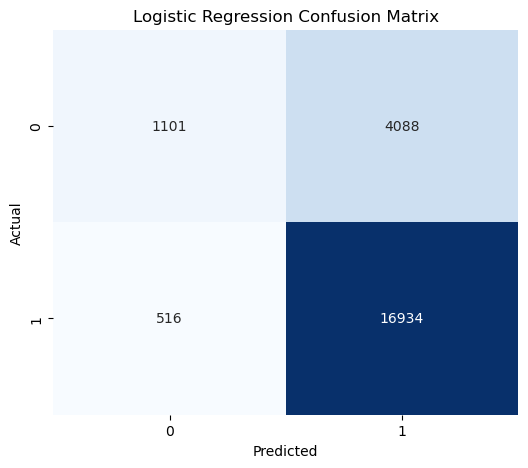

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.21      0.32      5189
           1       0.81      0.97      0.88     17450

    accuracy                           0.80     22639
   macro avg       0.74      0.59      0.60     22639
weighted avg       0.78      0.80      0.75     22639

Evaluating Decision Tree


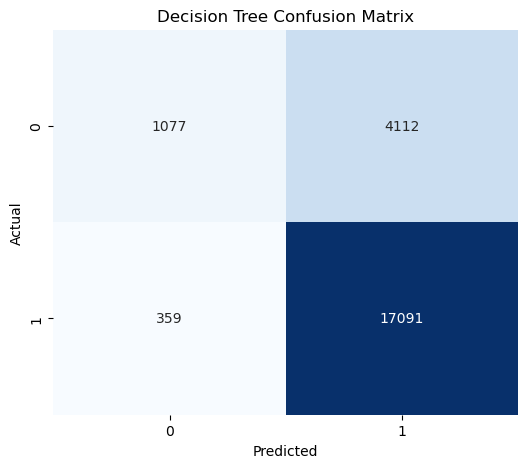

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.21      0.33      5189
           1       0.81      0.98      0.88     17450

    accuracy                           0.80     22639
   macro avg       0.78      0.59      0.60     22639
weighted avg       0.79      0.80      0.76     22639

Evaluating Random Forest


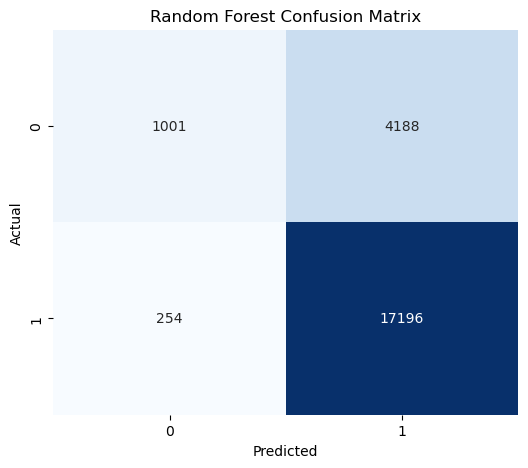

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.19      0.31      5189
           1       0.80      0.99      0.89     17450

    accuracy                           0.80     22639
   macro avg       0.80      0.59      0.60     22639
weighted avg       0.80      0.80      0.75     22639

Evaluating XGBoost


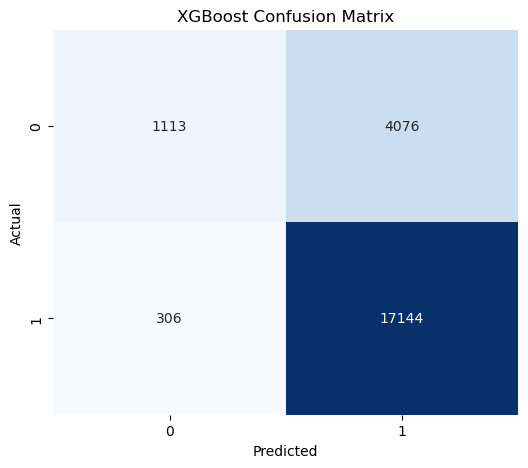

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.21      0.34      5189
           1       0.81      0.98      0.89     17450

    accuracy                           0.81     22639
   macro avg       0.80      0.60      0.61     22639
weighted avg       0.80      0.81      0.76     22639



In [73]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Selecting only the top 6 features
top_6_features = ['estimated_vs_actual_shipping', 'order_month', 'order_hour', 'price', 'payment_sequential', 'order_value', 'payment_installments']
X = merged_df[top_4_features]
y = merged_df['satisfaction']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline for numerical features
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Applying ColumnTransformer to preprocess the data
preprocessor = ColumnTransformer(
    transformers=[('num', numerical_transformer, top_4_features)]
)

# Preprocessing the data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_split=50),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10, min_samples_split=10, min_samples_leaf=4),
    'XGBoost': xgb.XGBClassifier(random_state=42)
}

# Function to fit models, make predictions, and evaluate them
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    
    # Plotting confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()
    
    print(f"{model_name} Classification Report:")
    print(class_report)

# Evaluate each model
for model_name, model in models.items():
    print(f"Evaluating {model_name}")
    evaluate_model(model, X_train_preprocessed, y_train, X_test_preprocessed, y_test, model_name)

In [74]:
from sklearn.model_selection import GridSearchCV

# Initialize the XGBoost Classifier
xgb_model = xgb.XGBClassifier(random_state=42)

# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 150],  # Fewer trees to keep the model simpler
    'max_depth': [3, 4, 5],          # Shallow trees to prevent overfitting
    'learning_rate': [0.1, 0.01, 0.05],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',  # or another scoring metric
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit GridSearchCV
grid_search.fit(X_train_preprocessed, y_train)

# Retrieve the best model
best_model = grid_search.best_estimator_

# Predictions
train_preds = best_model.predict(X_train_preprocessed)
test_preds = best_model.predict(X_test_preprocessed)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


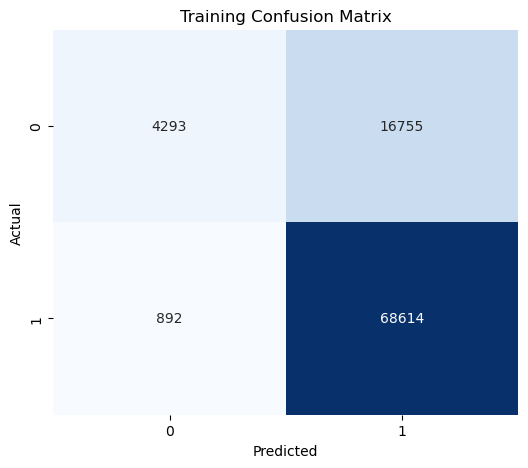

Training Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.20      0.33     21048
           1       0.80      0.99      0.89     69506

    accuracy                           0.81     90554
   macro avg       0.82      0.60      0.61     90554
weighted avg       0.81      0.81      0.76     90554



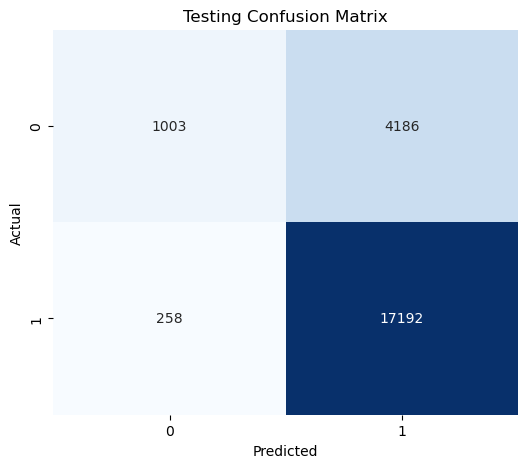

Testing Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.19      0.31      5189
           1       0.80      0.99      0.89     17450

    accuracy                           0.80     22639
   macro avg       0.80      0.59      0.60     22639
weighted avg       0.80      0.80      0.75     22639

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150, 'subsample': 0.8}
Best Score: 0.8014775608575576


In [75]:
# Function to plot confusion matrix
def plot_confusion_matrix(true_values, predictions, set_name):
    matrix = confusion_matrix(true_values, predictions)
    plt.figure(figsize=(6,5))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{set_name} Confusion Matrix')
    plt.show()

# Function to print classification report
def print_classification_report(true_values, predictions, set_name):
    report = classification_report(true_values, predictions)
    print(f"{set_name} Classification Report:")
    print(report)

# Visualize and print reports for both sets
plot_confusion_matrix(y_train, train_preds, "Training")
print_classification_report(y_train, train_preds, "Training")

plot_confusion_matrix(y_test, test_preds, "Testing")
print_classification_report(y_test, test_preds, "Testing")

# Print best parameters
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

In [33]:
# from sklearn.model_selection import RandomizedSearchCV

# Initialize the base RandomForestClassifier
# random_forest = RandomForestClassifier(random_state=42, class_weight='balanced')

# Define the parameter grid
# param_grid = {
    # 'n_estimators': [50, 100],  # fewer trees
    # 'max_depth': [5, 10],  # shallower trees
    # 'min_samples_split': [10, 20],
    # 'min_samples_leaf': [5, 10]
# }

# Initialize RandomizedSearchCV
# random_search = RandomizedSearchCV(estimator=random_forest,
                                   # param_distributions=param_grid,
                                   # n_iter=10,  # fewer iterations
                                   # cv=3,  # reduce if necessary
                                   # n_jobs=-1,
                                   # verbose=2,
                                   # random_state=42)

# Fit RandomizedSearchCV to the preprocessed training data
# random_search.fit(X_train_preprocessed, y_train)

# Retrieve the best model
# best_rf = random_search.best_estimator_

# Optionally, print the best parameters found
# print("Best Parameters:", random_search.best_params_)

In [76]:
# Create the final pipeline using the best model
final_pipeline = Pipeline(steps=[('preprocessing', preprocessor),
    ('classifier', xgb_model)
])

final_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['payment_value',
                                                   'time_to_delivery',
                                                   'estimated_vs_actual_shipping',
                                                   'late_delivery'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, devic...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [77]:
# Fit the pipeline to your data
final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['payment_value',
                                                   'time_to_delivery',
                                                   'estimated_vs_actual_shipping',
                                                   'late_delivery'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, devic...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [78]:
X_train.columns

Index(['payment_value', 'time_to_delivery', 'estimated_vs_actual_shipping',
       'late_delivery'],
      dtype='object')

In [79]:
X_train.describe()

,payment_value,time_to_delivery,estimated_vs_actual_shipping,late_delivery
count,90554.000000,90554.000000,90554.000000,90554.000000
mean,171.102164,11.520728,11.095081,0.076971
std,263.791159,9.416932,10.177117,0.266546
min,0.000000,-7.000000,-189.000000,0.000000
25%,60.640000,6.000000,6.000000,0.000000
50%,107.780000,9.000000,12.000000,0.000000
75%,188.667500,15.000000,16.000000,0.000000
max,13664.080000,208.000000,146.000000,1.000000


In [80]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90554 entries, 73387 to 16559
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   payment_value                 90554 non-null  float64
 1   time_to_delivery              90554 non-null  int64  
 2   estimated_vs_actual_shipping  90554 non-null  int64  
 3   late_delivery                 90554 non-null  int32  
dtypes: float64(1), int32(1), int64(2)
memory usage: 3.1 MB


In [38]:
# 3) Save pipeline as pkl file
import joblib

joblib.dump(final_pipeline, 'final_ECommerce_model.pkl')

['final_ECommerce_model.pkl']

In [39]:
model = joblib.load('final_ECommerce_model.pkl')

### Testing

In [82]:
import random

class SatisfactionFinder:
    def __init__(self, model, preprocessor, features, trials=50):
        self.model = model
        self.preprocessor = preprocessor
        self.features = features
        self.trials = trials

    def random_input(self):
        """Generate a random input within plausible ranges for each feature."""
        ranges = {
            'estimated_vs_actual_shipping': (-189, 146),
            'time_to_delivery': (-7, 208),  # Updated with correct range
            'payment_value': (0.0, 13664.08),  # Updated with correct range
            'order_item_id': (1.0, 21.0),  # Updated with correct range
            'late_delivery': (0, 1)  # Binary feature
        }

        # Generate a random value within each range
        return {feature: random.uniform(*ranges[feature]) if isinstance(ranges[feature][0], float)
                else random.randint(*ranges[feature]) for feature in self.features}

    def find_not_satisfied(self):
        """Loop to find a set of values that predict 'Not Satisfied'."""
        for _ in range(self.trials):
            # Generate random input
            user_data = self.random_input()

            # Convert to DataFrame
            input_df = pd.DataFrame([user_data])

            # Preprocess and predict
            input_preprocessed = self.preprocessor.transform(input_df)
            prediction = self.model.predict(input_preprocessed)

            # Check if prediction is 'Not Satisfied'
            if prediction[0] == 0:
                return user_data, "Not Satisfied"

        return None, "Not found"

# Assuming xgb_model, preprocessor, and top_6_features are previously defined
finder = SatisfactionFinder(xgb_model, preprocessor, ['estimated_vs_actual_shipping', 'time_to_delivery', 'payment_value', 'late_delivery'], trials=200)

# Find a 'Not Satisfied' prediction
user_data, result = finder.find_not_satisfied()

print("User Data:", user_data)
print("Result:", result)


User Data: {'estimated_vs_actual_shipping': 111, 'time_to_delivery': 202, 'payment_value': 8688.208815108223, 'late_delivery': 0}
Result: Not Satisfied


In [83]:
model.predict(pd.DataFrame([{
    'estimated_vs_actual_shipping': 130,
    'time_to_delivery': 133, 
    'payment_value': 9591,
    'late_delivery': 1 
}], dtype=float))

array([0])

In [85]:
model.predict(pd.DataFrame([{
    'estimated_vs_actual_shipping': 5,
    'time_to_delivery': 7,
    'payment_value': 300,
    'late_delivery': 0 
}], dtype=float))

array([1])

In [5]:
%%writefile ECB.py

import streamlit as st
import joblib
import numpy as np

# Load your trained pipeline
model = joblib.load('final_ECommerce_model.pkl')

# Define the structure of your app
def main():
    st.title('Customer Satisfaction Prediction App')

   # Define inputs with appropriate ranges and default values based on your data
    estimated_vs_actual_shipping = st.number_input('Estimated vs Actual Shipping Days', min_value=-189, max_value=146, value=11)
    time_to_delivery = st.number_input('Time to Delivery', min_value=-7, max_value=208, value=9)
    payment_value = st.number_input('Payment Value', min_value=0.0, max_value=13664.08, value=107.78)
    late_delivery = st.number_input('Late Delivery', min_value=0, max_value=1, value=0) 

# Prediction button
    if st.button('Predict Satisfaction'):
        # Create an array with the input data
        # Make sure all inputs are included in the array in the correct order
        input_data = np.array([[estimated_vs_actual_shipping, time_to_delivery, payment_value, late_delivery]])

        # Get the prediction
        prediction = model.predict(input_data)

        # Output the prediction
        if prediction[0] == 1:
            st.success('The customer is satisfied.')
        else:
            st.error('The customer is not satisfied')

if __name__ == '__main__':
    main()

Overwriting ECB.py


In [2]:
import ipywidgets as widgets
from IPython.display import display, HTML
import joblib
import pandas as pd

# Custom CSS to increase the font size and prevent collapsing
style = """
<style>
.widget-label { min-width: 25ex !important; }
.widget-label p { font-size: 16px !important; }
.slider-width { width: 100% !important; } /* Adjust the width as needed */
</style>
"""

# Display the custom CSS
display(HTML(style))

# Load your trained model
model = joblib.load('final_ECommerce_model.pkl')

# Define layout for the sliders
slider_layout = widgets.Layout(width='500px')  # Adjust the width as needed

# Create input widgets for user input with updated ranges and types
estimated_vs_actual_shipping = widgets.IntSlider(
    value=11, min=-189, max=146, step=1,
    description='Estimated vs Actual Shipping Days:',
    style={'description_width': 'initial'},  # Prevent collapsing
    layout=slider_layout
)

time_to_delivery = widgets.IntSlider(
    value=9, min=-7, max=208, step=1,
    description='Time to Delivery:',
    style={'description_width': 'initial'},  # Prevent collapsing
    layout=slider_layout
)

payment_value = widgets.FloatSlider(
    value=107.78, min=0.0, max=13664.08, step=0.01,
    description='Payment Value:',
    style={'description_width': 'initial'},  # Prevent collapsing
    layout=slider_layout
)

late_delivery = widgets.IntSlider(
    value=0, min=0, max=1, step=1,
    description='Late Delivery:',
    style={'description_width': 'initial'},  # Prevent collapsing
    layout=slider_layout
)

# Create a button widget for making predictions
predict_button = widgets.Button(description='Predict Satisfaction')

# Define a function to make predictions and display the result
def predict_satisfaction(b):
    # Collect values from widgets and create a DataFrame for prediction
    user_input = pd.DataFrame({
        'estimated_vs_actual_shipping': [estimated_vs_actual_shipping.value],
        'time_to_delivery': [time_to_delivery.value],
        'payment_value': [payment_value.value],
        'late_delivery': [late_delivery.value]
    })

    # Predict using the model
    prediction = model.predict(user_input)
    
    # Update the result label based on the prediction
    if prediction[0] == 1:
        result_label.value = 'The customer is satisfied.'
    else:
        result_label.value = 'The customer is not satisfied.'

# Attach the predict_satisfaction function to the button's click event
predict_button.on_click(predict_satisfaction)

# Create a label widget to display the prediction result
result_label = widgets.Label()

# Display the input widgets and the result label
input_widgets = [
    estimated_vs_actual_shipping,
    time_to_delivery,
    payment_value,
    late_delivery,
    predict_button,
    result_label  # This should also be included in the list to be displayed
]

for widget in input_widgets:
    display(widget)


IntSlider(value=11, description='Estimated vs Actual Shipping Days:', layout=Layout(width='500px'), max=146, m…

IntSlider(value=9, description='Time to Delivery:', layout=Layout(width='500px'), max=208, min=-7, style=Slide…

FloatSlider(value=107.78, description='Payment Value:', layout=Layout(width='500px'), max=13664.08, step=0.01,…

IntSlider(value=0, description='Late Delivery:', layout=Layout(width='500px'), max=1, style=SliderStyle(descri…

Button(description='Predict Satisfaction', style=ButtonStyle())

Label(value='')